<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/BOW_FCNN_TwitterDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import kagglehub
import os

In [ ]:

# Kaggle dataset download
path = kagglehub.dataset_download("sudishbasnet/truthseekertwitterdataset2023")
dataset_dir = "/root/.cache/kagglehub/datasets/sudishbasnet/truthseekertwitterdataset2023/"

# Dynamically locate the CSV file
file_name = None
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if "Truth_Seeker_Model_Dataset" in file and file.endswith(".csv"):
            file_name = os.path.join(root, file)
            break

# Ensure the file is found
if not file_name:
    raise FileNotFoundError("Truth_Seeker_Model_Dataset.csv not found in the extracted dataset.")

# Load the dataset
df = pd.read_csv(file_name)

# Display dataset preview and statistics
print("Dataset preview:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

# Handle missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)
df.dropna(subset=['tweet', 'BinaryNumTarget'], inplace=True)

# Rename columns for consistency
df.rename(columns={'tweet': 'text', 'BinaryNumTarget': 'label'}, inplace=True)

# Display dataset after renaming columns
print("\nRenamed dataset preview:")
print(df.head())

Dataset preview:
   Unnamed: 0      author                                          statement  \
0           0  D.L. Davis  End of eviction moratorium means millions of A...   
1           1  D.L. Davis  End of eviction moratorium means millions of A...   
2           2  D.L. Davis  End of eviction moratorium means millions of A...   
3           3  D.L. Davis  End of eviction moratorium means millions of A...   
4           4  D.L. Davis  End of eviction moratorium means millions of A...   

   target  BinaryNumTarget                 manual_keywords  \
0    True              1.0  Americans, eviction moratorium   
1    True              1.0  Americans, eviction moratorium   
2    True              1.0  Americans, eviction moratorium   
3    True              1.0  Americans, eviction moratorium   
4    True              1.0  Americans, eviction moratorium   

                                               tweet 5_label_majority_answer  \
0  @POTUS Biden Blunders - 6 Month Update\n\nInfl

In [ ]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

# Add filtering for texts with len < 50
new_data = []
new_labels = []
for text, label in zip(df['processed_text'], df['label']):
    if len(text) >= 50:  # Filter out texts shorter than 50 characters
        new_data.append(text)
        new_labels.append(label)

filtered_df = pd.DataFrame({'text': new_data, 'label': new_labels})

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    filtered_df['text'], filtered_df['label'], test_size=0.2, random_state=42
)


In [ ]:
# Tfidf Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

# Convert labels to tensors
train_labels = torch.tensor(train_labels.values, dtype=torch.long)
test_labels = torch.tensor(test_labels.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), train_labels)
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:
# Define the Neural Network
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 2

model = TextClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.numpy())
        y_true.extend(y_batch.numpy())


Epoch 1/10, Loss: 362.4594
Epoch 2/10, Loss: 201.5270
Epoch 3/10, Loss: 150.6724
Epoch 4/10, Loss: 95.3270
Epoch 5/10, Loss: 46.4673
Epoch 6/10, Loss: 18.4839
Epoch 7/10, Loss: 7.0793
Epoch 8/10, Loss: 3.7693
Epoch 9/10, Loss: 2.5512
Epoch 10/10, Loss: 2.3117



Model Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.98      0.98     12951
        True       0.98      0.98      0.98     13675

    accuracy                           0.98     26626
   macro avg       0.98      0.98      0.98     26626
weighted avg       0.98      0.98      0.98     26626



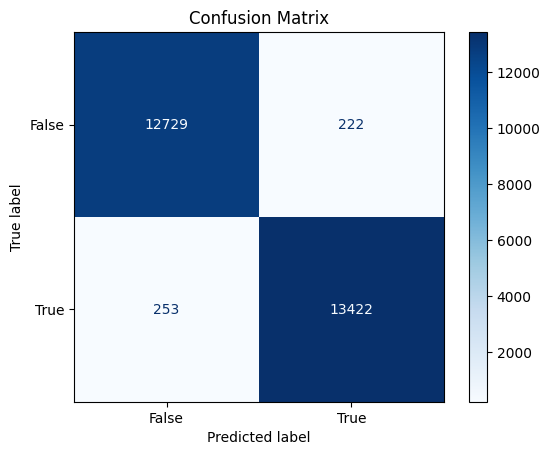


Sample Predictions:

Sample 1
Text: irvleavitt davechappelle its not entirely clear that marriage equality will survive the trump court and its important to remember that in most of america it is still perfectly legal to fire someone for being a gay lesbian bisexual or transgendered person
Predicted: True, Actual: True

Sample 2
Text: the good news about rand paul  plagiarizing gattaca is that at least hes found an idea not copied from his father
Predicted: True, Actual: True

Sample 3
Text: ones vaccination status is considered medical information and should fall the hipaa as private wishing a quick recovery
Predicted: False, Actual: False

Sample 4
Text: tianamen1989 153dontdoxmepls natsecjeff really this one taliban fighter is enough for your 100 soldiers wasted your your billion of dollars for nothing you can come  to afghanistan by your will but cant go without the afghans will afghanistan is the hell of invaders
Predicted: False, Actual: True

Sample 5
Text: us population growth

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['False', 'True']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['False', 'True'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Display a few predictions
print("\nSample Predictions:")
for i, (text, pred, true_label) in enumerate(zip(test_texts[:5], y_pred[:5], test_labels[:5])):
    print(f"\nSample {i+1}")
    print(f"Text: {text}")
    print(f"Predicted: {'True' if pred else 'False'}, Actual: {'True' if true_label else 'False'}")